In [2]:
import pandas as pd
import numpy as np
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random

In [4]:
df_housing = pd.read_csv('/content/housing.csv')
df_concrete = pd.read_csv('/content/concreteData.csv')
df_yatch = pd.read_csv('/content/yachtData.csv')

In [5]:
class LinearRegression:
    def __init__(self,X,y,learning_rate, lambda_l2, epsilon,max_iteration, error='rmse', gd= False, sgd = False) -> None:
      self.X = X
      self.y = y
      self.learning_rate = learning_rate
      self.lambda_l2 = lambda_l2
      self.epsilon = epsilon
      self.max_iteration = max_iteration
      self.gd = gd
      self.sgd = sgd
      self.error = error

    def split_data(self):
      X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size = 0.3,
                                                            random_state = 0)
      return X_train, X_test, y_train, y_test

    def add_x0(self,X):
      return np.column_stack([np.ones([X.shape[0], 1]), X])

    def normalize_train(self, X):

      mean = np.mean(X,0)
      std = np.std(X,0)
      X_norm = (X - mean) / std
      X_norm = self.add_x0(X_norm)
      return X_norm, mean, std

    def normalize_test(self, X_test, mean, std):

        X_norm = (X_test - mean) / std
        X_norm = self.add_x0(X_norm)
        return X_norm

    def rank(self, X):

      u,s,v=np.linalg.svd(X)
      return len([x for x in s if x>0.0005])

    def check_fullRank(self,X):

      rank = self.rank(X)
      if rank == min(X.shape):
        self.full_rank = True
        print('X is full rank')
      else:
        self.full_rank = False
        print('X is not low rank')

    def check_lowRank(self, X):

      if X.shape[0] < X.shape[1]:
        self.low_rank = True
        print('X is low rank')
      else:
        self.low_rank = False
        print('X is not low rank')

    def closed_form_solution(self, X, y):
      identity_matrix = np.identity(X.shape[1])
      regularization_term = self.lambda_l2 * identity_matrix
      self.theta = np.linalg.inv(X.T.dot(X) + regularization_term).dot(X.T).dot(y)

    def predict(self, X):
      return X.dot(self.theta)

    def sse(self, X, y):
      y_hat = self.predict(X)
      return ((y_hat - y )**2).sum()

    def rmse(self, X, y):

        return np.sqrt(self.sse(X, y) / X.shape[0])

    def cost_function(self, X, y):
      return self.sse(X,y)/2

    def cost_derivative(self, X, y):
      y_hat = self.predict(X)
      grad = (y_hat - y).dot(X)

      return grad

    def gradient_descent(self, X, y):
      errors = []

      prev_error =  np.float('inf')

      for i in tqdm(range(self.max_iteration)):
        self.theta -= self.learning_rate * (self.cost_derivative(X,y) + (self.lambda_l2 * self.theta))

        if self.error == 'rmse':
          current_error = self.rmse(X, y)
        else:
          current_error = self.sse(X, y)

        error_difference = prev_error - current_error
        prev_error = current_error

        errors.append(current_error)
        if abs(error_difference) < self.epsilon:
          print('Model stopped learning')
          break

      self.plot_rmse(errors)

      return

    def stochastic_gradient_descent(self, X, y):
        errors = []
        last_error = float('inf')

        for t in tqdm(range(self.max_iteration)):
            index = [random.randint(0,X.shape[0]-1) for i in np.arange(1,100,1)]
            X = X[index]
            y = y[index]

            self.theta = self.theta - self.learning_rate * (self.cost_derivative(X, y) + (self.lambda_l2 * self.theta))

            if self.error == 'rmse':
                current_error = self.rmse(X, y)
            else:
                current_error = self.sse(X, y)

            error_difference = last_error - current_error
            last_error = current_error

            errors.append(current_error)

            if abs(error_difference) < self.epsilon:
                print("model stopped learning")
                break

        self.plot_rmse(errors)

        return


    def fit(self):
      X_train,X_test,y_train,y_test = self.split_data()
      X_train, mean, std = self.normalize_train(X_train)
      X_test = self.normalize_test(X_test, mean, std)
      self.check_fullRank(X_train)
      self.check_lowRank(X_train)

      if self.full_rank and not self.low_rank and X_train.shape[1] < 1000 and\
       not self.gd and not self.sgd:
          self.closed_form_solution(X_train, y_train)
          test_sse = self.sse(X_test, y_test)
          test_rmse = self.rmse(X_test, y_test)
      elif self.gd:
          self.theta = np.ones(X_train.shape[1], dtype = np.float64)
          self.gradient_descent(X_train, y_train)
          test_sse = self.sse(X_test, y_test)
          test_rmse = self.rmse(X_test, y_test)
      elif self.sgd:
          self.theta = np.ones(X_train.shape[1], dtype = np.float64)
          self.stochastic_gradient_descent(X_train, y_train)
          test_sse = self.sse(X_test, y_test)
          test_rmse = self.rmse(X_test, y_test)

      print(self.theta)
      print('SSE:', test_sse)
      print('RMSE:', test_rmse)



    def plot_rmse(self, error_sequence):
        """
        @X: error_sequence, vector of rmse
        @does: Plots the error function
        @return: plot
        """
        s = np.array(error_sequence)
        t = np.arange(s.size)

        fig, ax = plt.subplots()
        ax.plot(t, s)

        ax.set(xlabel='iterations', ylabel=list(range(len(error_sequence))), title = 'Cost_function')
        ax.grid()

        plt.legend(bbox_to_anchor=(1.05,1), loc=2, shadow=True)
        plt.show()


## Closed Form Solution without Regularisation - Housing

In [6]:
lr_closed_form = lr_wo_l2 = LinearRegression(df_housing.values[:,:-1], df_housing.values[:,-1], learning_rate = 0.0004, lambda_l2 = 0,
                      epsilon = 0.005, max_iteration = 50000, gd = False, sgd=False)

In [7]:
lr_closed_form.fit()

X is full rank
X is not low rank
[22.93399433 -0.90751811  1.04796575  0.38867104  0.6622465  -2.17214484
  2.58716716  0.50645061 -2.59559964  2.30818886 -1.67320027 -2.33651383
  0.65618617 -3.99472177]
SSE: 3250.0044107893395
RMSE: 4.624025082730341


## Closed Form Solution with Regularisation - Housing

In [8]:
lr_closed_form_r = lr_wo_l2 = LinearRegression(df_housing.values[:,:-1], df_housing.values[:,-1], learning_rate = 0.0004, lambda_l2 = 2,
                      epsilon = 0.005, max_iteration = 50000, gd = False, sgd=False)

In [9]:
lr_closed_form_r.fit()

X is full rank
X is not low rank
[22.80478873 -0.88980745  1.01305949  0.32762176  0.67107478 -2.08806017
  2.61206607  0.46710827 -2.54218216  2.14187751 -1.52792414 -2.31260454
  0.65438184 -3.94967401]
SSE: 3250.4756627313986
RMSE: 4.624360313323716


## Gradient Descent without Regularisation - Housing

In [10]:
lr_gr_wo_r = LinearRegression(df_housing.values[:,:-1], df_housing.values[:,-1], learning_rate = 0.0004, lambda_l2 = 0,
                      epsilon = 0.005, max_iteration = 50000, gd = True, sgd=False)

<ipython-input-5-6f6d3b70dfc4>:87: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  prev_error =  np.float('inf')


X is full rank
X is not low rank


  0%|          | 35/50000 [00:00<00:10, 4858.70it/s]


Model stopped learning


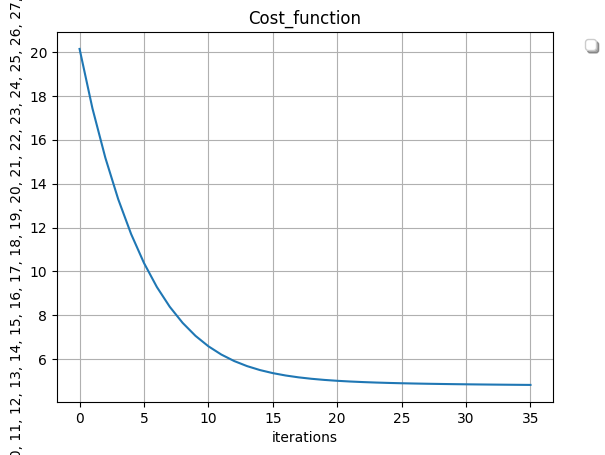

[ 2.28425344e+01 -6.85120332e-01  6.30274322e-01  4.21925698e-03
  7.35534040e-01 -8.90442563e-01  3.25733508e+00  1.86687918e-01
 -1.56620915e+00  7.45799651e-01 -5.56294061e-01 -2.05752219e+00
  7.05062262e-01 -3.47191145e+00]
SSE: 3449.930267964322
RMSE: 4.764127376305131


In [11]:
lr_gr_wo_r.fit()

## Gradient Descent with Regularisation - Housing

In [12]:
lr_gr_w_r = LinearRegression(df_housing.values[:,:-1], df_housing.values[:,-1], learning_rate = 0.0004, lambda_l2 = 2,
                      epsilon = 0.005, max_iteration = 50000, gd = True, sgd=False)

<ipython-input-5-6f6d3b70dfc4>:87: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  prev_error =  np.float('inf')


X is full rank
X is not low rank


  0%|          | 36/50000 [00:00<00:08, 5859.33it/s]


Model stopped learning


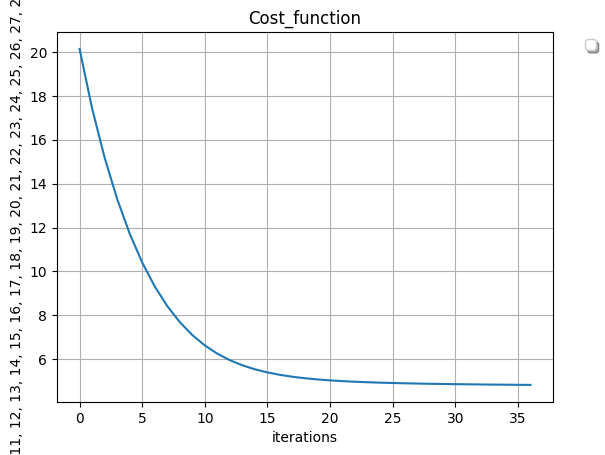

[ 2.27293522e+01 -6.87728656e-01  6.31155933e-01 -3.40631562e-03
  7.33868449e-01 -9.11438242e-01  3.22682824e+00  1.78887910e-01
 -1.58706070e+00  7.52961365e-01 -5.56359263e-01 -2.05845562e+00
  6.98627152e-01 -3.47343737e+00]
SSE: 3441.681032988361
RMSE: 4.758428141195727


In [13]:
lr_gr_w_r.fit()

## Stochastic Gradient Descent without Regularisation - Housing

In [14]:
lr_sgd_wo_r = LinearRegression(df_housing.values[:,:-1], df_housing.values[:,-1], learning_rate = 0.0004, lambda_l2 = 0,
                      epsilon = 0.005, error='rmse', max_iteration = 50000, gd = False, sgd=True)

X is full rank
X is not low rank


  0%|          | 28/50000 [00:00<00:27, 1816.78it/s]


model stopped learning


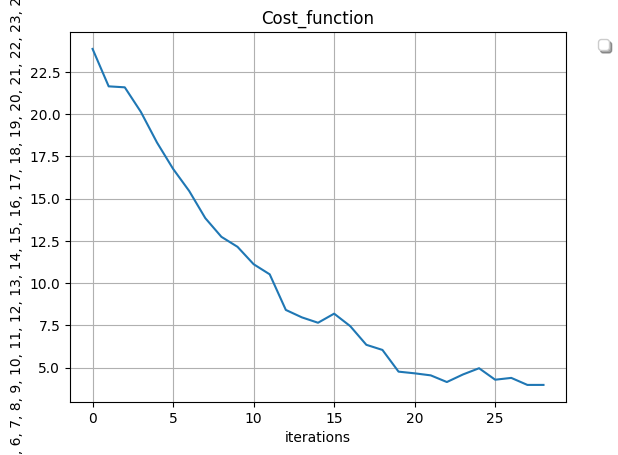

[12.18652877 -1.67968999 -0.95375925  1.86992747 -0.79959472 -0.6304694
  1.54330255 -2.2661306   2.39628649 -3.30374065 -2.33038527 -2.81407352
 -0.25975705 -2.84356229]
SSE: 31619.014657599393
RMSE: 14.422892680515938


In [15]:
lr_sgd_wo_r.fit()

## Stochastic Gradient Descent with Regularisation - Housing

In [16]:
lr_sgd_w_r = LinearRegression(df_housing.values[:,:-1], df_housing.values[:,-1], learning_rate = 0.0004, lambda_l2 = 2,
                      epsilon = 0.005, error='rmse', max_iteration = 50000, gd = False, sgd=True)

X is full rank
X is not low rank


  0%|          | 33/50000 [00:00<00:22, 2241.42it/s]


model stopped learning


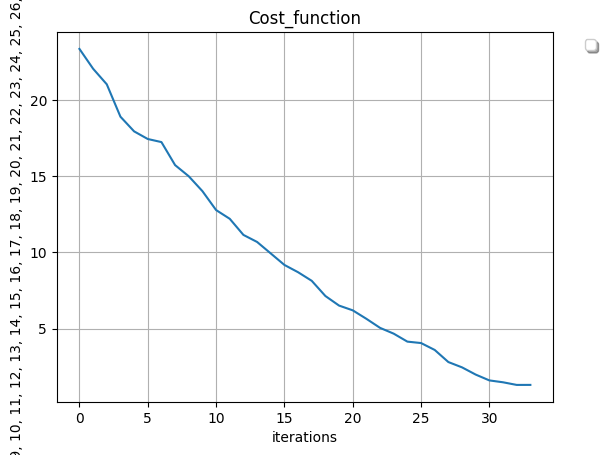

[13.91279498 -0.26489366  1.30353904 -3.18541568 -1.11394545 -0.83873813
  1.03863692  2.63018326  0.04710813 -1.71227361 -4.06197765 -1.80050851
  3.78270894  0.80187064]
SSE: 24187.36356786682
RMSE: 12.614570618687766


In [17]:
lr_sgd_wo_r.fit()

## Closed Form Solution without Regularisation - Concrete

In [18]:
lr_closed_form_concrete = LinearRegression(df_concrete.values[:,:-1], df_concrete.values[:,-1], learning_rate = 0.0007, lambda_l2 = 0,
                      epsilon = 0.0001, max_iteration = 50000, gd = False, sgd=False)

In [19]:
lr_closed_form_concrete.fit()

X is full rank
X is not low rank
[35.55869444 13.07061719  9.29612788  6.07754028 -2.38797659  2.13444427
  1.74782814  1.75752107  7.36636378]
SSE: 38115.41391778251
RMSE: 11.106342967100199


## Closed Form Solution with Regularisation - Concrete

In [20]:
lr_closed_form_r_concrete = LinearRegression(df_concrete.values[:,:-1], df_concrete.values[:,-1], learning_rate = 0.0007, lambda_l2 = 2,
                      epsilon = 0.0001, max_iteration = 50000, gd = False, sgd=False)

In [21]:
lr_closed_form_r_concrete.fit()

X is full rank
X is not low rank
[35.46019391 12.56442678  8.78870435  5.62902223 -2.72588056  2.13595515
  1.40318242  1.31122058  7.32490463]
SSE: 38068.254287199656
RMSE: 11.099469984605458


## Gradient Descent without Regularisation - Concrete

In [22]:
lr_gr_wo_r_concrete = LinearRegression(df_concrete.values[:,:-1], df_concrete.values[:,-1], learning_rate = 0.0007, lambda_l2 = 0,
                      epsilon = 0.0001, max_iteration = 50000, gd = True, sgd=False)

<ipython-input-5-6f6d3b70dfc4>:87: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  prev_error =  np.float('inf')


X is full rank
X is not low rank


  0%|          | 126/50000 [00:00<00:04, 11919.67it/s]


Model stopped learning


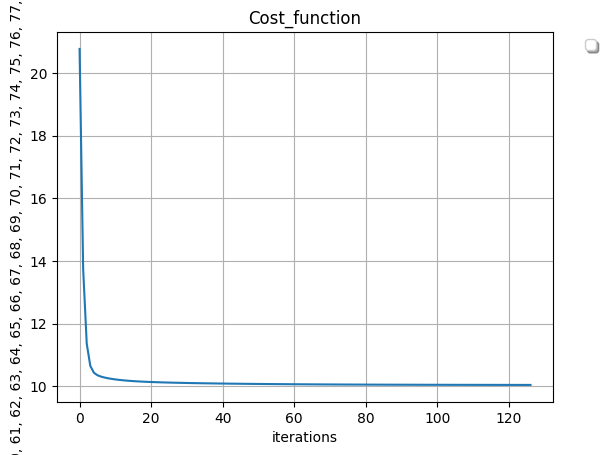

[35.55869444 12.44284025  8.66167093  5.52846866 -2.91914237  2.06819033
  1.25669173  1.14573239  7.34776238]
SSE: 38079.170223535366
RMSE: 11.10106123728563


In [23]:
lr_gr_wo_r_concrete.fit()

## Gradient Descent with Regularisation - Concrete

In [24]:
lr_gr_w_r_concrete = LinearRegression(df_concrete.values[:,:-1], df_concrete.values[:,-1], learning_rate = 0.0007, lambda_l2 = 2,
                      epsilon = 0.0001, max_iteration = 50000, gd = True, sgd=False)

<ipython-input-5-6f6d3b70dfc4>:87: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  prev_error =  np.float('inf')


X is full rank
X is not low rank


  0%|          | 134/50000 [00:00<00:04, 10605.27it/s]


Model stopped learning


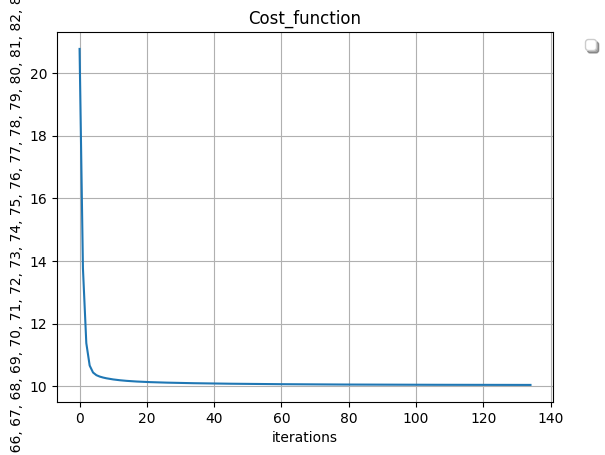

[35.46019391 12.15422137  8.37413403  5.27024626 -3.07296394  2.09265721
  1.08225769  0.91146003  7.31275046]
SSE: 38056.981043410946
RMSE: 11.097826406533397


In [25]:
lr_gr_w_r_concrete.fit()

## Stochastic Gradient Descent without Regularisation - Concrete

In [26]:
lr_sgd_wo_r_concrete = LinearRegression(df_concrete.values[:,:-1], df_concrete.values[:,-1], learning_rate = 0.0007, lambda_l2 = 0,
                      epsilon = 0.0001, error='rmse', max_iteration = 50000, gd = False, sgd=True)

X is full rank
X is not low rank


  0%|          | 76/50000 [00:00<00:21, 2373.21it/s]


model stopped learning


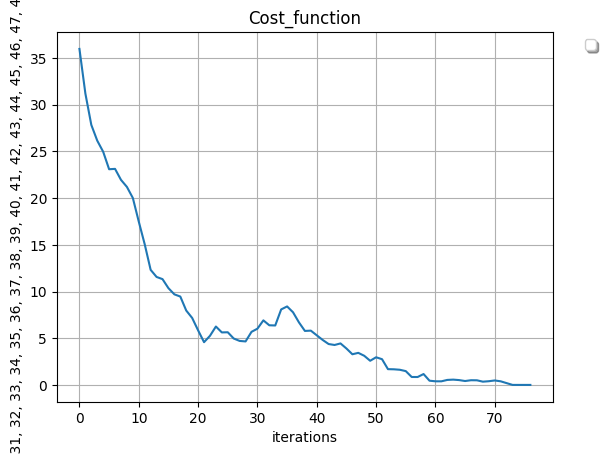

[ 28.69737591   6.35191385   5.00475007  -2.52235461 -10.30568629
  -1.25184103  -0.88326906   6.404057    -2.56921723]
SSE: 124266.89381849399
RMSE: 20.053883225507988


In [27]:
lr_sgd_wo_r_concrete.fit()

## Stochastic Gradient Descent with Regularisation - Concrete

In [28]:
lr_sgd_w_r_concrete = LinearRegression(df_concrete.values[:,:-1], df_concrete.values[:,-1], learning_rate = 0.0007, lambda_l2 = 2,
                      epsilon = 0.0001, error='rmse', max_iteration = 50000, gd = False, sgd=True)

X is full rank
X is not low rank


  0%|          | 132/50000 [00:00<00:19, 2611.09it/s]


model stopped learning


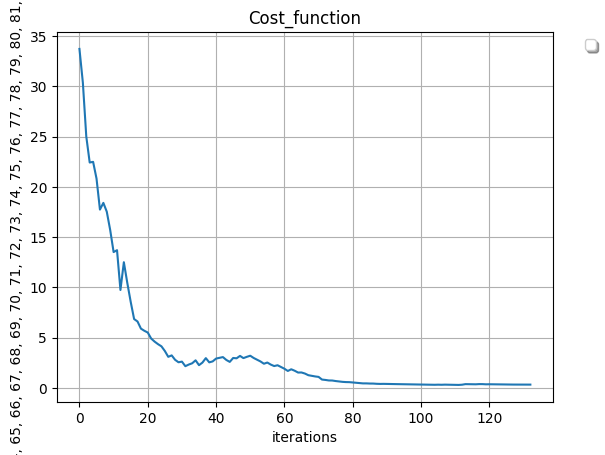

[21.22702847  3.3835273  -2.90004776  2.7513186   5.56772406  4.80027563
 -3.1223531  -2.33837238 -2.05750804]
SSE: 162015.83069963113
RMSE: 22.898102032654048


In [29]:
lr_sgd_w_r_concrete.fit()

## Closed Form Solution without Regularisation - Yacht

In [30]:
lr_closed_form_yacht = lr_wo_l2 = LinearRegression(df_yatch.values[:,:-1], df_yatch.values[:,-1], learning_rate = 0.001, lambda_l2 = 0,
                      epsilon = 0.001, max_iteration = 50000, gd = False, sgd=False)

In [31]:
lr_closed_form_yacht.fit()

X is full rank
X is not low rank
[10.74271028  0.54271589 -0.48644592  0.53145418 -0.58852203 -0.84401335
 12.89451446]
SSE: 7619.253689071981
RMSE: 9.051378846467502


## Closed Form Solution with Regularisation - Yacht

In [32]:
lr_closed_form_r_yacht = lr_wo_l2 = LinearRegression(df_yatch.values[:,:-1], df_yatch.values[:,-1], learning_rate = 0.001, lambda_l2 = 2,
                      epsilon = 0.001, max_iteration = 50000, gd = False, sgd=False)

In [33]:
lr_closed_form_r_yacht.fit()

X is full rank
X is not low rank
[10.64324074  0.53769453 -0.57735329  0.13980756 -0.26922183 -0.46666467
 12.77278684]
SSE: 7557.8964823809365
RMSE: 9.01486018258869


## Gradient Descent without Regularisation - Yacht

In [34]:
lr_gr_wo_r_yacht = LinearRegression(df_yatch.values[:,:-1], df_yatch.values[:,-1], learning_rate = 0.001, lambda_l2 = 0,
                      epsilon = 0.001, max_iteration = 50000, gd = True, sgd=False)

<ipython-input-5-6f6d3b70dfc4>:87: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  prev_error =  np.float('inf')


X is full rank
X is not low rank


  0%|          | 18/50000 [00:00<00:02, 17260.51it/s]


Model stopped learning


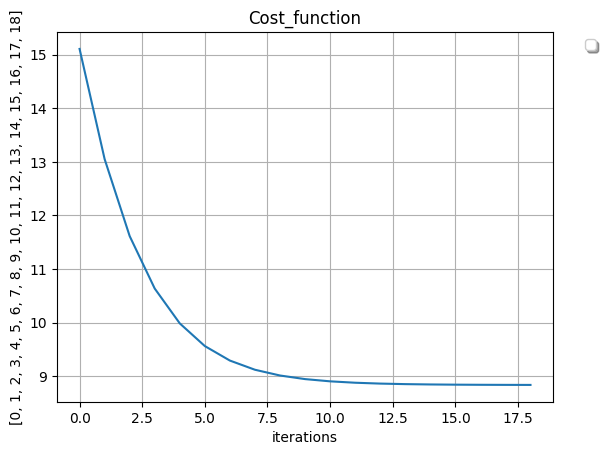

[10.64231619  0.55899327 -0.67286189 -0.31656289  0.09170956 -0.02711927
 12.76487365]
SSE: 7562.670311115541
RMSE: 9.017706781848306


In [35]:
lr_gr_wo_r_yacht.fit()

## Gradient Descent with Regularisation - Yacht

In [36]:
lr_gr_w_r_yacht = LinearRegression(df_yatch.values[:,:-1], df_yatch.values[:,-1], learning_rate = 0.001, lambda_l2 = 2,
                      epsilon = 0.001, max_iteration = 50000, gd = True, sgd=False)

<ipython-input-5-6f6d3b70dfc4>:87: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  prev_error =  np.float('inf')


X is full rank
X is not low rank


  0%|          | 20/50000 [00:00<00:02, 18587.65it/s]


Model stopped learning


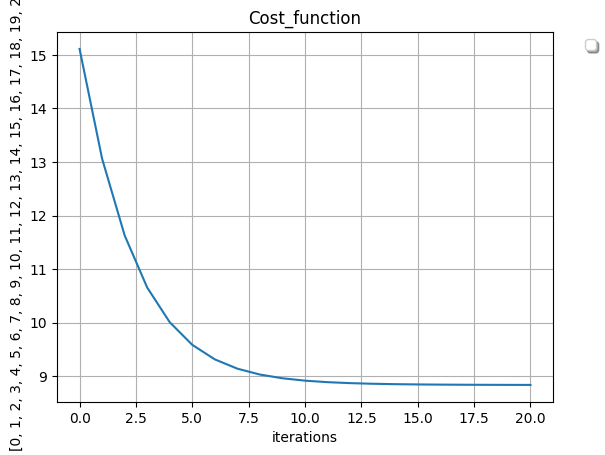

[10.58504914  0.54875193 -0.67253533 -0.30511907  0.08604961 -0.03774024
 12.69771769]
SSE: 7527.551299032089
RMSE: 8.996744512186025


In [37]:
lr_gr_w_r_yacht.fit()

## Stochastic Gradient Descent without Regularisation - Yacht

In [38]:
lr_sgd_wo_yacht = LinearRegression(df_yatch.values[:,:-1], df_yatch.values[:,-1], learning_rate = 0.001, lambda_l2 = 0,
                      epsilon = 0.001, error='rmse', max_iteration = 50000, gd = False, sgd=True)

X is full rank
X is not low rank


  0%|          | 68/50000 [00:00<00:21, 2319.52it/s]


model stopped learning


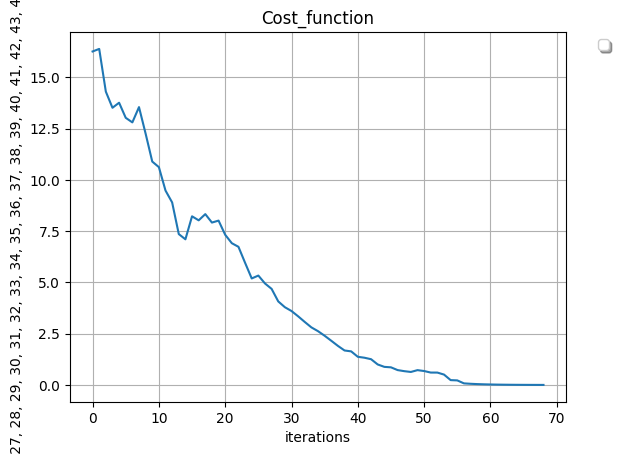

[ 1.50473683e+01  1.90671895e+00  9.68233698e-01  5.78915857e+00
  6.37192022e+00 -1.27186537e-02  2.02165019e+01]
SSE: 26238.457759250174
RMSE: 16.796843584451796


In [39]:
lr_sgd_wo_yacht.fit()

## Stochastic Gradient Descent with Regularisation - Yacht

In [40]:
lr_sgd_w_r_yacht = LinearRegression(df_yatch.values[:,:-1], df_yatch.values[:,-1], learning_rate = 0.001, lambda_l2 = 2,
                      epsilon = 0.001, error='rmse', max_iteration = 50000, gd = False, sgd=True)

X is full rank
X is not low rank


  0%|          | 86/50000 [00:00<00:19, 2506.76it/s]


model stopped learning


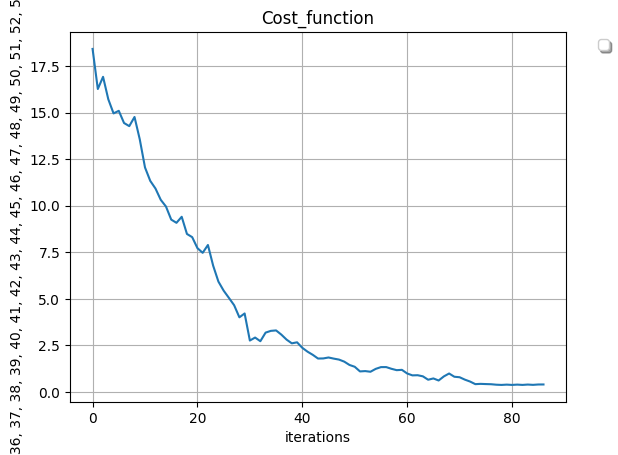

[ 1.57420302e+01  6.15293692e+00  7.93345178e-01 -3.13760256e+00
 -3.70366559e+00  1.88545752e-02  2.11753048e+01]
SSE: 28226.26607705711
RMSE: 17.421487806376092


In [41]:
lr_sgd_w_r_yacht.fit()

# Conclusion
### * For closed form solution the value of Theta decreases with regularization whereas RMSE and SSE slightly decreases for all the three datasets  - L2 regularization with a lambda value of 2 had a minimal impact on the model's performance

### * For gradient descent RMSE and SSE decreases after regularization for all the three datasets which signifies that L2 regularization with an appropriate lambda value has improved the model's performance by reducing overfitting and making it more generalizable

### * For stochastic gradient descent RMSE and SSE decreases after regularization for housing dataset - L2 regularization applied with lambda = 2 has encouraged the model to have smaller coefficients. This leads to a simpler model that is less likely to overfit the training data. The lower RMSE in the regularized model indicates that it performs slightly better on the training data, which suggests that the regularization helps in reducing overfitting

### * For stochastic gradient descent RMSE and SSE increased after regularization for concrete and yacht dataset - The increase in RMSE and SSE, when regularization is applied, signifies that the model has become more robust and less prone to overfitting. It's now less likely to capture noise in the training data, and its predictions are expected to generalize better to unseen data. And decreased theta values signifies the impact of L2 regularization in penalizing large coefficients. The regularization term discourages extreme values in the coefficients and encourages simpler models